# Conformational sampling analysis

Analyze conformational sampling of **SM46** (dihedrals) in octanol and gas phase.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import tqdm

import pathlib
import os.path
import itertools

import alchemlyb.parsing.gmx

In [9]:
DATADIRS = [pathlib.Path("../_dih_analysis/"), 
            pathlib.Path("../_dih_gaff/"),
            pathlib.Path("../_dih_ligpargen/")
           ]
FIGURES = pathlib.Path("../figs/dihedrals")

FIGURES.mkdir(parents=True, exist_ok=True)

In [10]:
def read_xvg(filepath):
    """Parse XVG file `filepath` into a DataFrame."""
    df = alchemlyb.parsing.gmx._extract_dataframe(filepath)
    df.reset_index(inplace=True)
    df.rename(columns={df.columns[0]: "time", df.columns[1]: "angle"}, inplace=True)
    return df

## Datafiles

### programmatic selection of data files

Save output data files in XVG format with a fixed filename that can be easily parsed for the metadata:

```
{forcefield}-{molid}-{solvent}-{interaction}-{lambda>}-{dih}-ts.xvg.bz2
```
* forcefield: cgenff, oplsaa, gaff, ligpargen
* molid: SM46, SM45, ...
* solvent: water, octanol
* lambda: 0000, 0050, ..., 0900, 1000
* dih: dih1, dih2

Files can be compressed with bzip2 or gzip.

In [11]:
forcefields = ("cgenff", "oplsaa", "ligpargen", "gaff")
solvents = ("water", "octanol")
interactions = ("Coulomb", "VDW") 

def get_metadata(filename):
    # molid, forcefield, solvent, interaction, lambda, dihnumber
    filename = pathlib.Path(filename)
    forcefield, molid, solvent, interaction, lmbda, dih, _ = filename.name.split("-")
    for value, allowed in zip([forcefield, solvent, interaction], [forcefields, solvents, interactions]):
        if value not in allowed:
            raise ValueError(f"{filename}: {value} not in {allowed})")
    return molid, forcefield, solvent, interaction, float(lmbda)/1000, dih, filename


Build a dataframe of all data files:

In [12]:
datafiles = pd.DataFrame([get_metadata(fn) for fn in                          
                          itertools.chain(*(d.glob("*-ts.xvg*") for d in DATADIRS))], 
                          columns=["molid", "forcefield", "solvent", "interaction",
                                   "lambda", "dihedral", "filename"])
datafiles = datafiles.sort_values(by=["molid", "forcefield", "dihedral", "solvent", 
                                      "interaction", "lambda"]).reset_index(drop=True)


In [13]:
datafiles.head(3)

,molid,forcefield,solvent,interaction,lambda,dihedral,filename
0,SM46,cgenff,octanol,Coulomb,0.000,dih1,../_dih_analysis/cgenff-SM46-octanol-Coulomb-0...
1,SM46,cgenff,octanol,Coulomb,0.000,dih1,../_dih_analysis/cgenff-SM46-octanol-Coulomb-0...
2,SM46,cgenff,octanol,Coulomb,0.125,dih1,../_dih_analysis/cgenff-SM46-octanol-Coulomb-0...


In [14]:
len(datafiles)

528

Using `groupby` we can generate appropriate selections of files:

In [15]:
g = datafiles.groupby(by=["forcefield", "molid", "dihedral"])

In [16]:
g.describe()

lambda                                              \
                           count      mean       std  min     25%   50%  75%   
forcefield molid dihedral                                                      
cgenff     SM46  dih1       88.0  0.522727  0.332477  0.0  0.2375  0.55  0.8   
                 dih2       88.0  0.522727  0.332477  0.0  0.2375  0.55  0.8   
gaff       SM46  dih1       44.0  0.522727  0.334404  0.0  0.2375  0.55  0.8   
                 dih2       44.0  0.522727  0.334404  0.0  0.2375  0.55  0.8   
ligpargen  SM46  dih1       44.0  0.522727  0.334404  0.0  0.2375  0.55  0.8   
                 dih2       44.0  0.522727  0.334404  0.0  0.2375  0.55  0.8   
oplsaa     SM46  dih1       88.0  0.522727  0.332477  0.0  0.2375  0.55  0.8   
                 dih2       88.0  0.522727  0.332477  0.0  0.2375  0.55  0.8   

                                
                           max  
forcefield molid dihedral       
cgenff     SM46  dih1      1.0  
                 dih2      1.0  
gaff       SM46  dih1      1.0  
                 dih2      1.0  
ligpargen  SM46  dih1      1.0  
                 dih2      1.0  
oplsaa     SM46  dih1      1.0  
                 dih2      1.0

To get a group, use `get_group()`:

In [17]:
g.get_group(("oplsaa", "SM46", "dih1")).head()

,molid,forcefield,solvent,interaction,lambda,dihedral,filename
352,SM46,oplsaa,octanol,Coulomb,0.000,dih1,../_dih_analysis/oplsaa-SM46-octanol-Coulomb-0...
353,SM46,oplsaa,octanol,Coulomb,0.000,dih1,../_dih_analysis/oplsaa-SM46-octanol-Coulomb-0...
354,SM46,oplsaa,octanol,Coulomb,0.125,dih1,../_dih_analysis/oplsaa-SM46-octanol-Coulomb-0...
355,SM46,oplsaa,octanol,Coulomb,0.125,dih1,../_dih_analysis/oplsaa-SM46-octanol-Coulomb-0...
356,SM46,oplsaa,octanol,Coulomb,0.250,dih1,../_dih_analysis/oplsaa-SM46-octanol-Coulomb-0...


###  Build long dataframe


Make a tidy data frame with all observations:
```molid forcefield solvent interaction lambda dihedral angle```: one data point (angle) per line.

Pad the data with periodic copies so that we can easily do correct distributions and KDEs.

In [18]:
def periodic_angle(df, padding=45):
    """pad with ±paddingº beyond the edges and return angle series"""
    df = df.angle.sort_values()
    return pd.concat([df[df > 180 - padding] - 360, df, df[df < -180 + padding] + 360]).reset_index(drop=True)

def extract(datafiles, start=None, stop=None, step=None):
    dataframes = []
    # get each row as a df
    for i in tqdm.tqdm(range(len(datafiles))):
        simulation = datafiles[i:i+1]
        a = periodic_angle(read_xvg(simulation.iloc[0].filename).iloc[start:stop:step])
        identifiers = simulation.drop(columns=["molid", "forcefield", "filename"])
        df = pd.concat(
               [pd.concat(len(a)*[identifiers], axis="index")
                .reset_index(drop=True), a], axis="columns")
        dataframes.append(df)
    return pd.concat(dataframes)

### How to extract datasets from a long dataframe with groupby

Get the data set with groupby and get_group():

In [304]:
wCoul = datafiles.groupby(by=["molid", "forcefield", "solvent", "interaction", "dihedral"]).get_group(
    ("SM46", "oplsaa", "water", "Coulomb", "dih1"))
wCoul

,molid,forcefield,solvent,interaction,lambda,dihedral,filename
111,SM46,oplsaa,water,Coulomb,0.00,dih1,../_dih_analysis/oplsaa-SM46-water-Coulomb-000...
112,SM46,oplsaa,water,Coulomb,0.25,dih1,../_dih_analysis/oplsaa-SM46-water-Coulomb-025...
113,SM46,oplsaa,water,Coulomb,0.50,dih1,../_dih_analysis/oplsaa-SM46-water-Coulomb-050...
114,SM46,oplsaa,water,Coulomb,0.75,dih1,../_dih_analysis/oplsaa-SM46-water-Coulomb-075...
115,SM46,oplsaa,water,Coulomb,1.00,dih1,../_dih_analysis/oplsaa-SM46-water-Coulomb-100...


In [305]:
df = extract(wCoul, step=100)

100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


In [306]:
df

,solvent,interaction,lambda,dihedral,angle
0,water,Coulomb,0.0,dih1,-224.999
1,water,Coulomb,0.0,dih1,-224.974
2,water,Coulomb,0.0,dih1,-224.956
3,water,Coulomb,0.0,dih1,-224.861
4,water,Coulomb,0.0,dih1,-224.855
...,...,...,...,...,...
996,water,Coulomb,1.0,dih1,33.239
997,water,Coulomb,1.0,dih1,63.972
998,water,Coulomb,1.0,dih1,65.883
999,water,Coulomb,1.0,dih1,70.759


<AxesSubplot:xlabel='angle', ylabel='Density'>

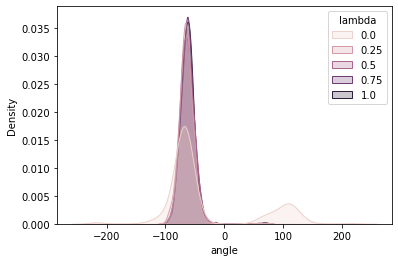

In [307]:
sns.kdeplot(x="angle", hue="lambda", data=df, bw_method="scott", common_norm=False,fill=True,  multiple="layer")

## Violinplots

### Plotting function
Seaborn categorical plots are useful to automatically generate facet grids, including ones with violins:


Plot all data for a molecule, forcefield, and dihedral:

- Needs the `datafiles` dataframe to find the filenames.
- Extracts the data (can take a while).
- Plots dihedral distributions in a split violin plot.
- Uses a stride of 100 (`step=100`) by default; test if more data improves the violins.
- Saves the file in `FIGDIR` with a generated filename `{molid}_{forcefield}_{dihedral}_violins.pdf"`

In [20]:
def dihedral_violins(df, width=0.9):
    """Plot distributions of all dihedrals as violin plots.
    
    Parameters
    ----------
    df : DataFrame
         long form dataframe with lambda, solvent, and interaction
    width : float
          width of the violin element (>1 overlaps)
         
    Returns
    -------
    seaborn.FacetGrid
    """
    # number of Coul windows + 1 / number of VDW windows
    # (+1 for additional space with axes)
    width_ratios = [len(df[df['interaction'] == "Coulomb"]["lambda"].unique()) + 1,
                    len(df[df['interaction'] == "VDW"]["lambda"].unique())]
    
    g = sns.catplot(data=df, x="lambda", y="angle", hue="solvent", col="interaction",
                    kind="violin", split=True, width=width, inner=None, cut=0,
                    linewidth=0.5,
                    hue_order=["water", "octanol"], col_order=["Coulomb", "VDW"],
                    sharex=False, sharey=True,
                    height=2, aspect=2,
                    facet_kws={'ylim': (-180, 180), 
                               'gridspec_kws': {'width_ratios': width_ratios, 
                                                # 'wspace': 0.03
                                                }})
    g.set_xlabels(r"$\lambda$")
    g.set_ylabels(r"dihedral angle $\phi$")
    g.despine(offset=5)

    axC = g.axes_dict['Coulomb']
    axC.yaxis.set_major_locator(plt.matplotlib.ticker.MultipleLocator(60))
    axC.yaxis.set_minor_locator(plt.matplotlib.ticker.MultipleLocator(30))
    axC.yaxis.set_major_formatter(plt.matplotlib.ticker.FormatStrFormatter(r"$%g^\circ$"))

    axV = g.axes_dict['VDW']
    axV.yaxis.set_visible(False)
    axV.spines["left"].set_visible(False)
    
    return g

def plot_violins(datafiles, molid, forcefield, dihedral, 
                 start=None, stop=None, step=100,
                 **kwargs):
    g = datafiles.groupby(by=["molid", "forcefield", "dihedral"])
    
    files = g.get_group((molid, forcefield, dihedral))
    
    df = extract(files, start=start, stop=stop, step=step)
    
    g = dihedral_violins(df, **kwargs)
    figfile = FIGURES / f"{molid}_{forcefield}_{dihedral}_violins.pdf"
    g.savefig(figfile)
    print(f"Violin plot saved to {figfile}.")
  
    return g

### SM46

Plot the two primary dihedrals of SM46 for different force fields:

#### OPLSAA (mol2ff)

100%|██████████| 44/44 [00:33<00:00,  1.33it/s]


Violin plot saved to ../figs/dihedrals/SM46_oplsaa_dih1_violins.pdf.


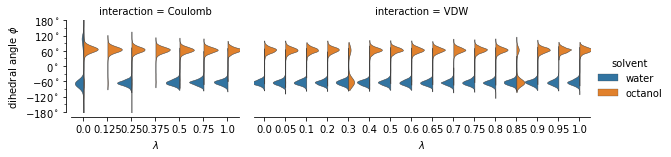

In [473]:
plot_violins(datafiles, "SM46", "oplsaa", "dih1", width=1.2)

100%|██████████| 44/44 [00:40<00:00,  1.10it/s]


Violin plot saved to ../figs/dihedrals/SM46_oplsaa_dih2_violins.pdf.


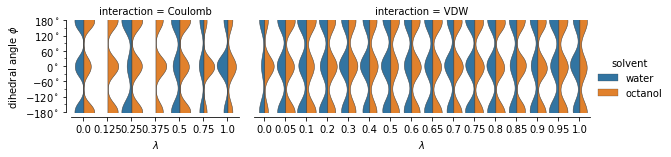

In [474]:
plot_violins(datafiles, "SM46", "oplsaa", "dih2")

#### CGENFF

100%|██████████| 44/44 [00:39<00:00,  1.11it/s]


Violin plot saved to ../figs/dihedrals/SM46_cgenff_dih1_violins.pdf.


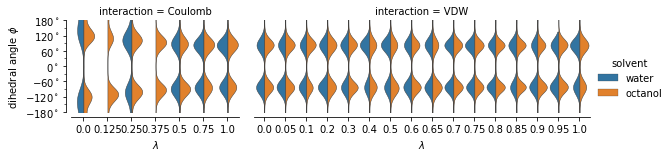

In [475]:
plot_violins(datafiles, "SM46", "cgenff", "dih1")

100%|██████████| 44/44 [00:48<00:00,  1.10s/it]


Violin plot saved to ../figs/dihedrals/SM46_cgenff_dih2_violins.pdf.


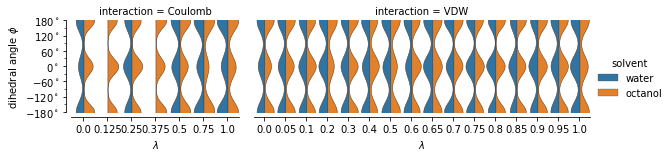

In [476]:
plot_violins(datafiles, "SM46", "cgenff", "dih2")

#### GAFF

100%|██████████| 44/44 [00:23<00:00,  1.89it/s]


Violin plot saved to ../figs/dihedrals/SM46_gaff_dih1_violins.pdf.


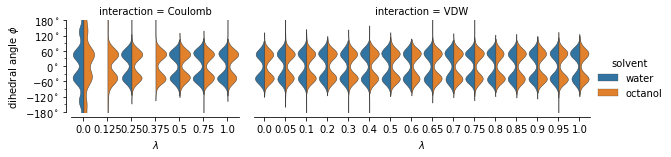

In [21]:
plot_violins(datafiles, "SM46", "gaff", "dih1")

100%|██████████| 44/44 [00:23<00:00,  1.89it/s]


Violin plot saved to ../figs/dihedrals/SM46_gaff_dih2_violins.pdf.


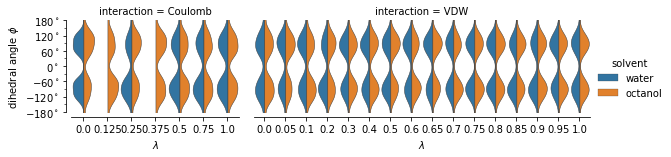

In [22]:
plot_violins(datafiles, "SM46", "gaff", "dih2")

#### OPLSAA (LigParGen)

100%|██████████| 44/44 [00:11<00:00,  3.81it/s]


Violin plot saved to ../figs/dihedrals/SM46_ligpargen_dih1_violins.pdf.


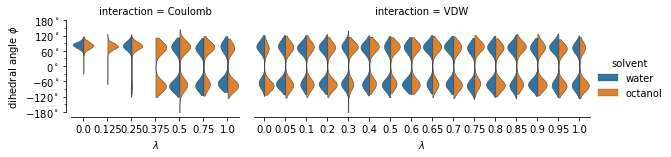

In [23]:
plot_violins(datafiles, "SM46", "ligpargen", "dih1")

100%|██████████| 44/44 [00:13<00:00,  3.26it/s]


Violin plot saved to ../figs/dihedrals/SM46_ligpargen_dih2_violins.pdf.


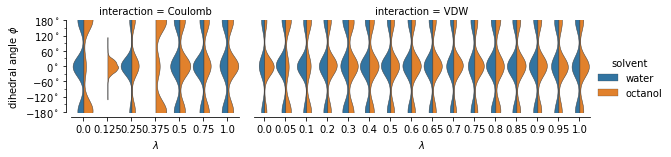

In [24]:
plot_violins(datafiles, "SM46", "ligpargen", "dih2")

## APPENDIX

### prototyping Violin plots

Figuring out what to plot and how. In the end, use `sns.catplot` to put it all together automatically.

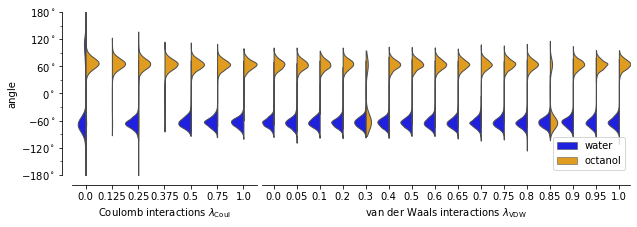

In [389]:
#palette_Coulomb = sns.cubehelix_palette(len(df_Coulomb['lambda'].unique()), rot=-.25, light=0.9, reverse=True)
#palette_VDW = sns.cubehelix_palette(len(df_VDW['lambda'].unique()), start=0.3, rot=0.3, light=0.9, reverse=True)

palette_w = sns.cubehelix_palette(len(df_Coulomb['lambda'].unique()), rot=-.25, light=0.9, reverse=True)
palette_o = sns.cubehelix_palette(len(df_Coulomb['lambda'].unique()), start=0.3, rot=-.25, light=0.9, reverse=True)


#import matplotlib.gridspec as grid_spec

fig = plt.figure(figsize=(10, 3))
gs = plt.matplotlib.gridspec.GridSpec(1, 2, width_ratios=[8, 16], figure=fig)

axC = fig.add_subplot(gs[0])
axV = fig.add_subplot(gs[1], sharey=axC)
sns.violinplot(x="lambda", y="angle", data=df_Coulomb,
               cut=0, scale="area", inner=None,
               split=True, hue="solvent", hue_order=["water", "octanol"],
               palette=["blue", "orange"],
               #palette=[palette_w, palette_o],
               linewidth=1, width=1.,
               ax=axC
              )
sns.violinplot(x="lambda", y="angle", data=df_VDW,
               cut=0, scale="area", inner=None,
               split=True, hue="solvent", hue_order=["water", "octanol"],
               palette=["blue", "orange"],
               linewidth=1, width=1.,
               ax=axV
              )

gs.update(wspace=0.02)
sns.despine(fig=fig, offset=10)

axC.set_xlabel(r"Coulomb interactions $\lambda_{\mathrm{Coul}}$")
axV.set_xlabel(r"van der Waals interactions $\lambda_{\mathrm{VDW}}$")

axC.yaxis.set_major_locator(plt.matplotlib.ticker.MultipleLocator(60))
axC.yaxis.set_minor_locator(plt.matplotlib.ticker.MultipleLocator(30))
axC.yaxis.set_major_formatter(plt.matplotlib.ticker.FormatStrFormatter(r"$%g^\circ$"))

axC.set_ylim(-180, 180)
axV.yaxis.set_visible(False)
axV.spines["left"].set_visible(False)

axC.legend_.set_visible(False)
axV.legend(loc="lower right")


/Users/oliver/anaconda3/envs/alchemlyb38/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
/Users/oliver/anaconda3/envs/alchemlyb38/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


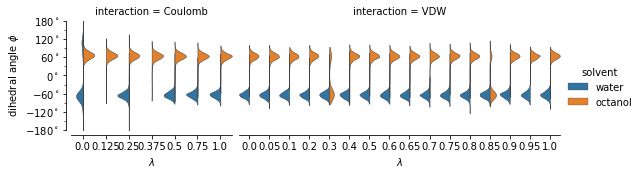

In [457]:
df = pd.concat([df_Coulomb, df_VDW]) # reconstruct full dataset

g = sns.catplot(data=df, x="lambda", y="angle", hue="solvent", col="interaction",
                kind="violin", split=True, width=1., inner=None, cut=0,
               linewidth=0.5,
               hue_order=["water", "octanol"], col_order=["Coulomb", "VDW"],
               sharex=False, sharey=True,
               height=2, aspect=2,
               facet_kws={'ylim': (-180, 180), 
                          'gridspec_kws': {'width_ratios': [8, 16], 'wspace': 0.03}})
g.set(ylim=(-180, 180))
g.set_xlabels(r"$\lambda$")
g.set_ylabels(r"dihedral angle $\phi$")
g.despine(offset=5)

axC = g.axes_dict['Coulomb']
axC.yaxis.set_major_locator(plt.matplotlib.ticker.MultipleLocator(60))
axC.yaxis.set_minor_locator(plt.matplotlib.ticker.MultipleLocator(30))
axC.yaxis.set_major_formatter(plt.matplotlib.ticker.FormatStrFormatter(r"$%g^\circ$"))

axV = g.axes_dict['VDW']
axV.yaxis.set_visible(False)
axV.spines["left"].set_visible(False)



## KDE ridgeplot
The rdigeplot is supposed to look like https://seaborn.pydata.org/examples/kde_ridgeplot.html but the overlapping between ridges does not work for me. So it's just a facet plot with each column corresponding to different solvent and each row to a different lambda value. Make separate plots dor *Coulomb* and *VDW*.

TODO: look at pure-matplotlib solution https://matplotlib.org/matplotblog/posts/create-ridgeplots-in-matplotlib/ or https://glowingpython.blogspot.com/2020/03/ridgeline-plots-in-pure-matplotlib.html

In [317]:
def kde_ridgeplot(df, interaction):
    n_windows = len(df['lambda'].unique())
    if interaction.lower() == "coulomb":
        pal = sns.cubehelix_palette(n_windows, rot=-.25, light=.6)
    elif interaction.lower() == "vdw":
        pal = sns.cubehelix_palette(n_windows, start=0.3, rot=0.3, light=.6)
    else:
        raise ValueError(f"interaction '{interaction}' must be Coulomb or VDW.")
        
    g = sns.FacetGrid(df, row="lambda", col="solvent", 
                      col_order=["water", "octanol"],
                      hue="lambda", aspect=10, height=1, palette=pal,
                      sharex=True, sharey=True, xlim=(-180, 180))
    # Draw the densities in a few steps
    g.map(sns.kdeplot, "angle",
          bw_adjust=1, clip_on=True,
          fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "angle", clip_on=True, color="k", lw=1, 
          bw_adjust=1)
    g.map(plt.axhline, y=0, lw=2, clip_on=True)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, "angle")

    # Set the subplots to overlap
    # does not work for my plot
    #g.fig.subplots_adjust(hspace=-0.25)

    # Remove axes details that don't play well with overlap
    #g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    
    return g



Make all plots for a specific molecule, forcefield, and dihedral.

In [294]:
def plot_kde_ridges(datafiles, molid, forcefield, dihedral, start=None, stop=None, step=100):
    g = datafiles.groupby(by=["molid", "forcefield", "dihedral", "interaction"])
    
    files_Coul = g.get_group((molid, forcefield, dihedral, 'Coulomb'))
    files_VDW = g.get_group((molid, forcefield, dihedral, 'VDW'))
    
    df_Coulomb = extract(files_Coul, start=start, stop=stop, step=step)
    df_VDW = extract(files_VDW, start=start, stop=stop, step=step)
    
    g_Coulomb = kde_ridgeplot(df_Coulomb, "Coulomb")
    figfile = FIGURES / f"{molid}_{forcefield}_{dihedral}_Coulomb.pdf"
    g_Coulomb.fig.savefig(figfile)
    print(f"Coulomb plot saved to {figfile}.")
    
    g_VDW = kde_ridgeplot(df_VDW, "VDW")
    figfile = FIGURES / f"{molid}_{forcefield}_{dihedral}_VDW.pdf"
    g_VDW.fig.savefig(figfile)
    print(f"VDW plot saved to {figfile}.")
    
    return g_Coulomb, g_VDW

100%|██████████| 32/32 [00:24<00:00,  1.30it/s]


Coulomb plot saved to ../figs/dihedrals/SM46_cgenff_dih1_Coulomb.pdf.
VDW plot saved to ../figs/dihedrals/SM46_cgenff_dih1_VDW.pdf.


(<seaborn.axisgrid.FacetGrid at 0x7fda4a0246a0>,
 <seaborn.axisgrid.FacetGrid at 0x7fda33b6afd0>)

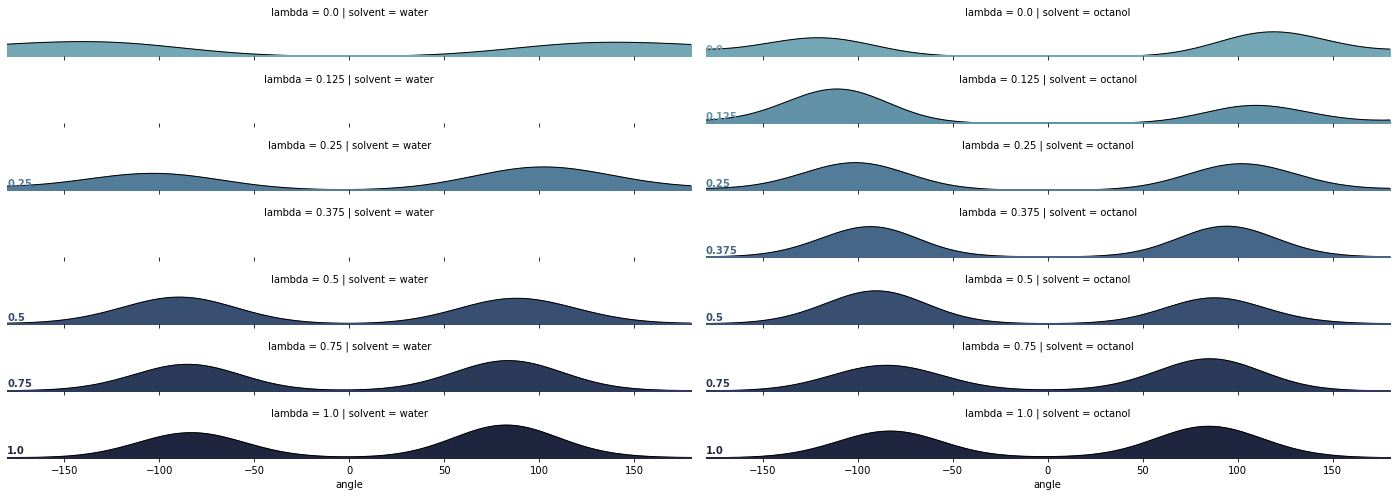

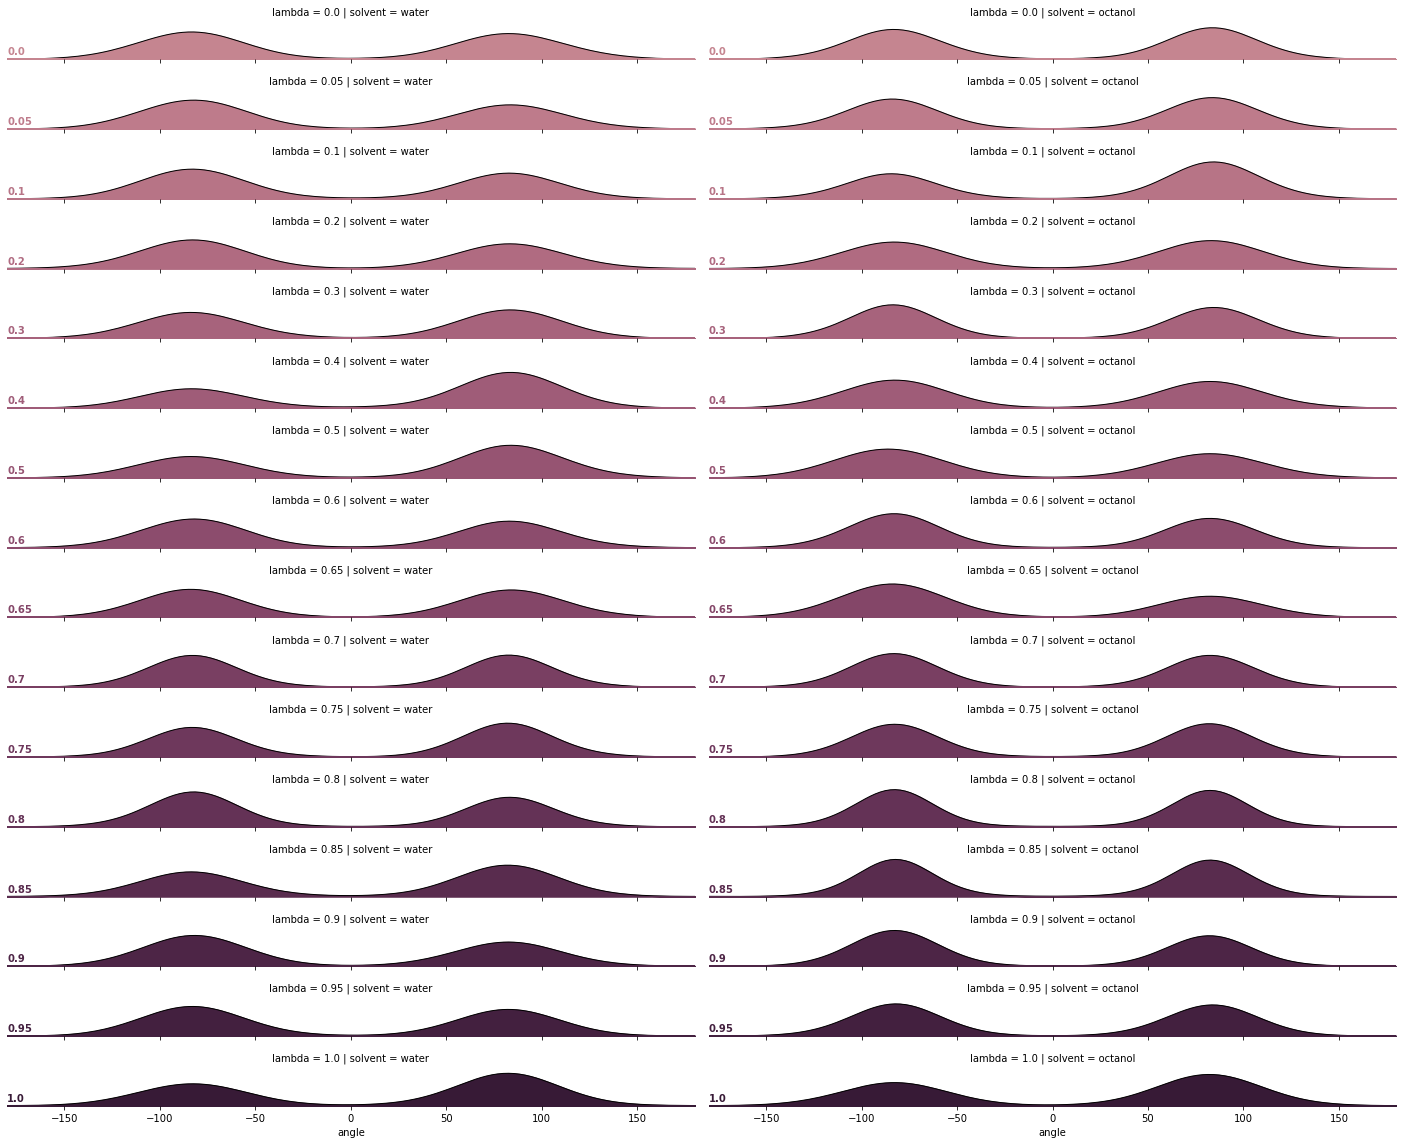

In [298]:
plot_kde_ridges(datafiles, "SM46", "cgenff", "dih1")

100%|██████████| 32/32 [00:29<00:00,  1.08it/s]


Coulomb plot saved to ../figs/dihedrals/SM46_cgenff_dih2_Coulomb.pdf.
VDW plot saved to ../figs/dihedrals/SM46_cgenff_dih2_VDW.pdf.


(<seaborn.axisgrid.FacetGrid at 0x7fda535d5a60>,
 <seaborn.axisgrid.FacetGrid at 0x7fda33cf76a0>)

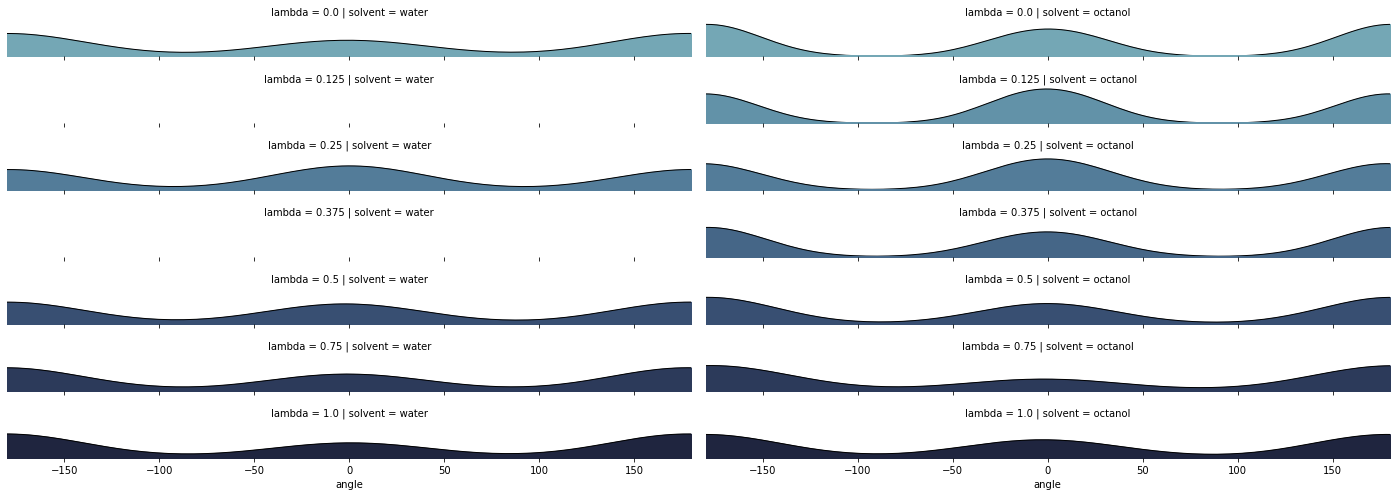

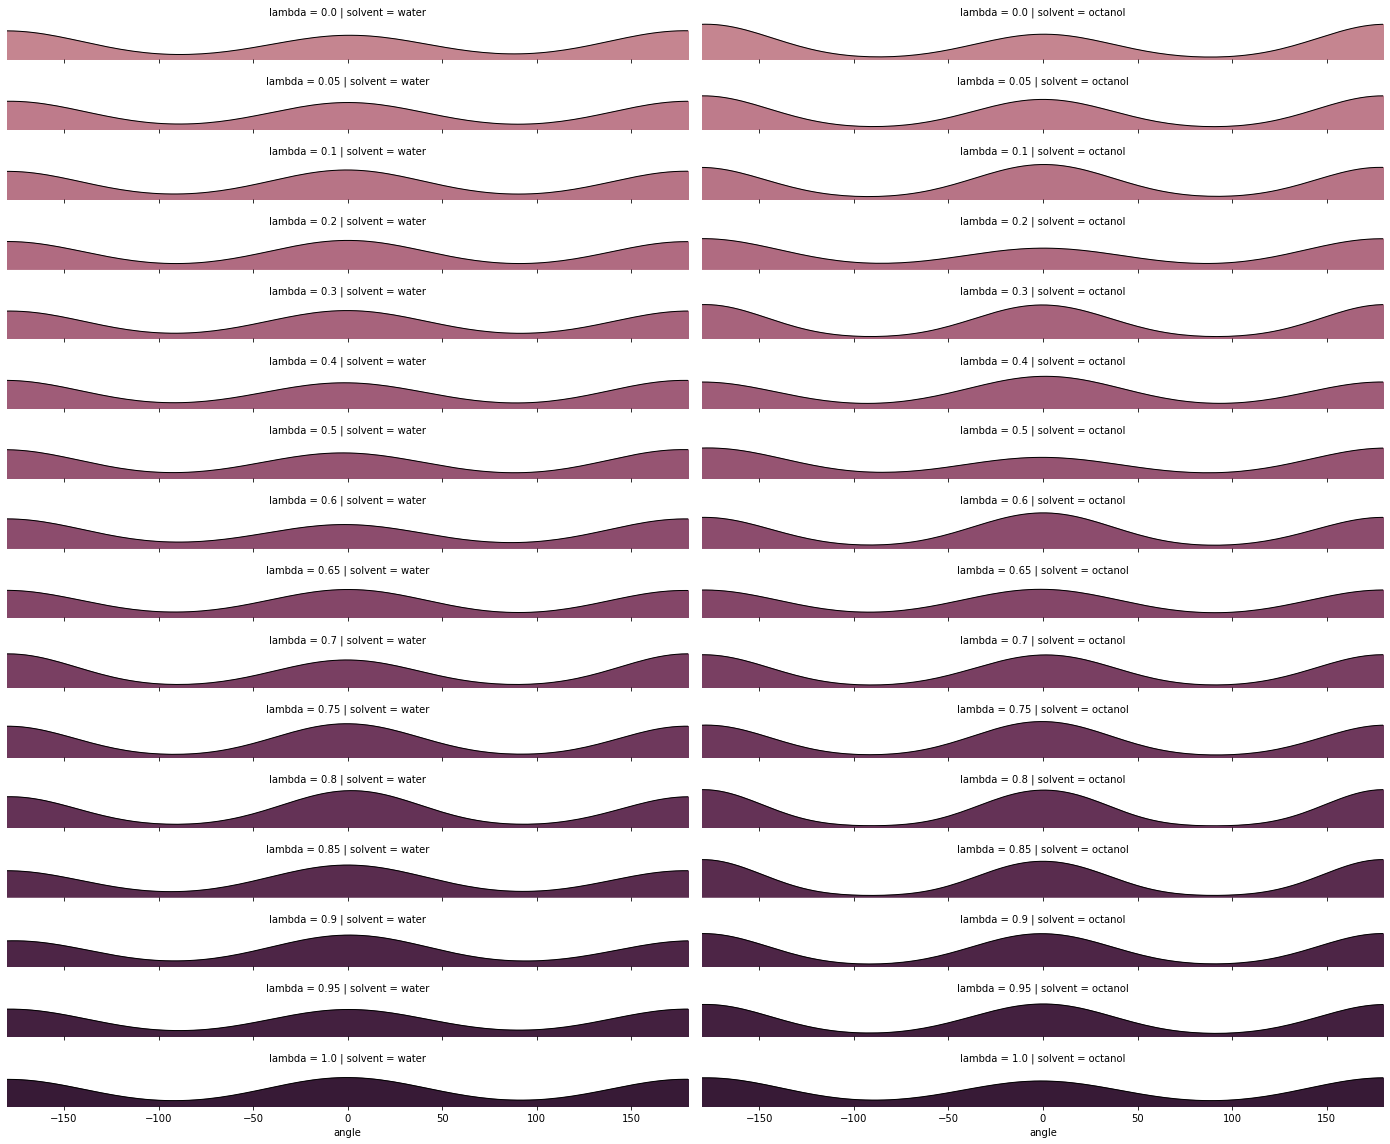

In [299]:
plot_kde_ridges(datafiles, "SM46", "cgenff", "dih2")

100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


Coulomb plot saved to ../figs/dihedrals/SM46_oplsaa_dih1_Coulomb.pdf.
VDW plot saved to ../figs/dihedrals/SM46_oplsaa_dih1_VDW.pdf.


(<seaborn.axisgrid.FacetGrid at 0x7fda342ee280>,
 <seaborn.axisgrid.FacetGrid at 0x7fda39238790>)

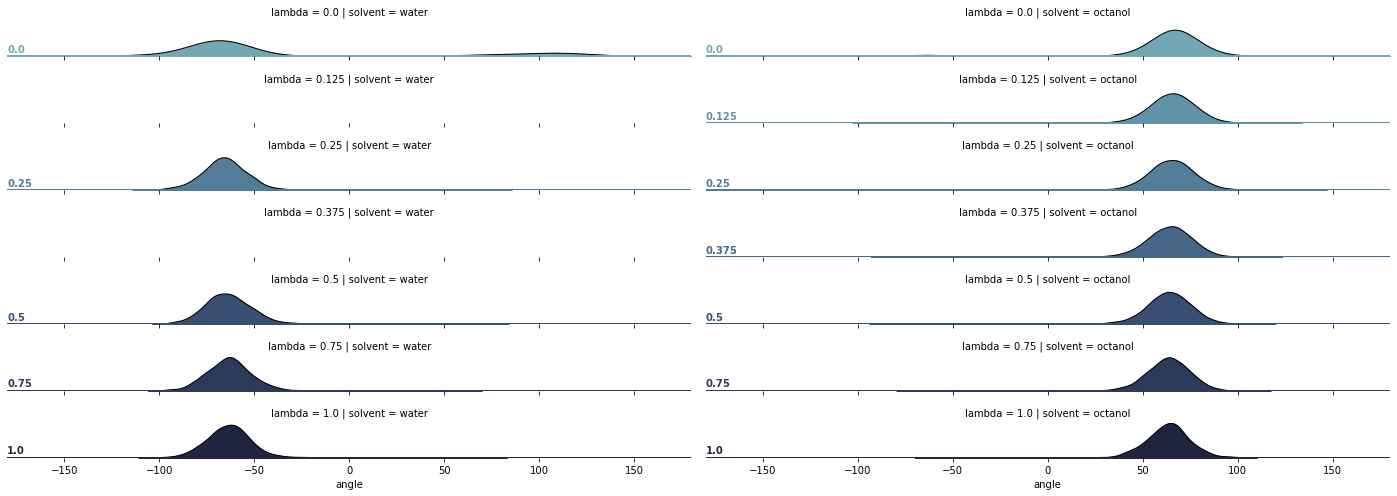

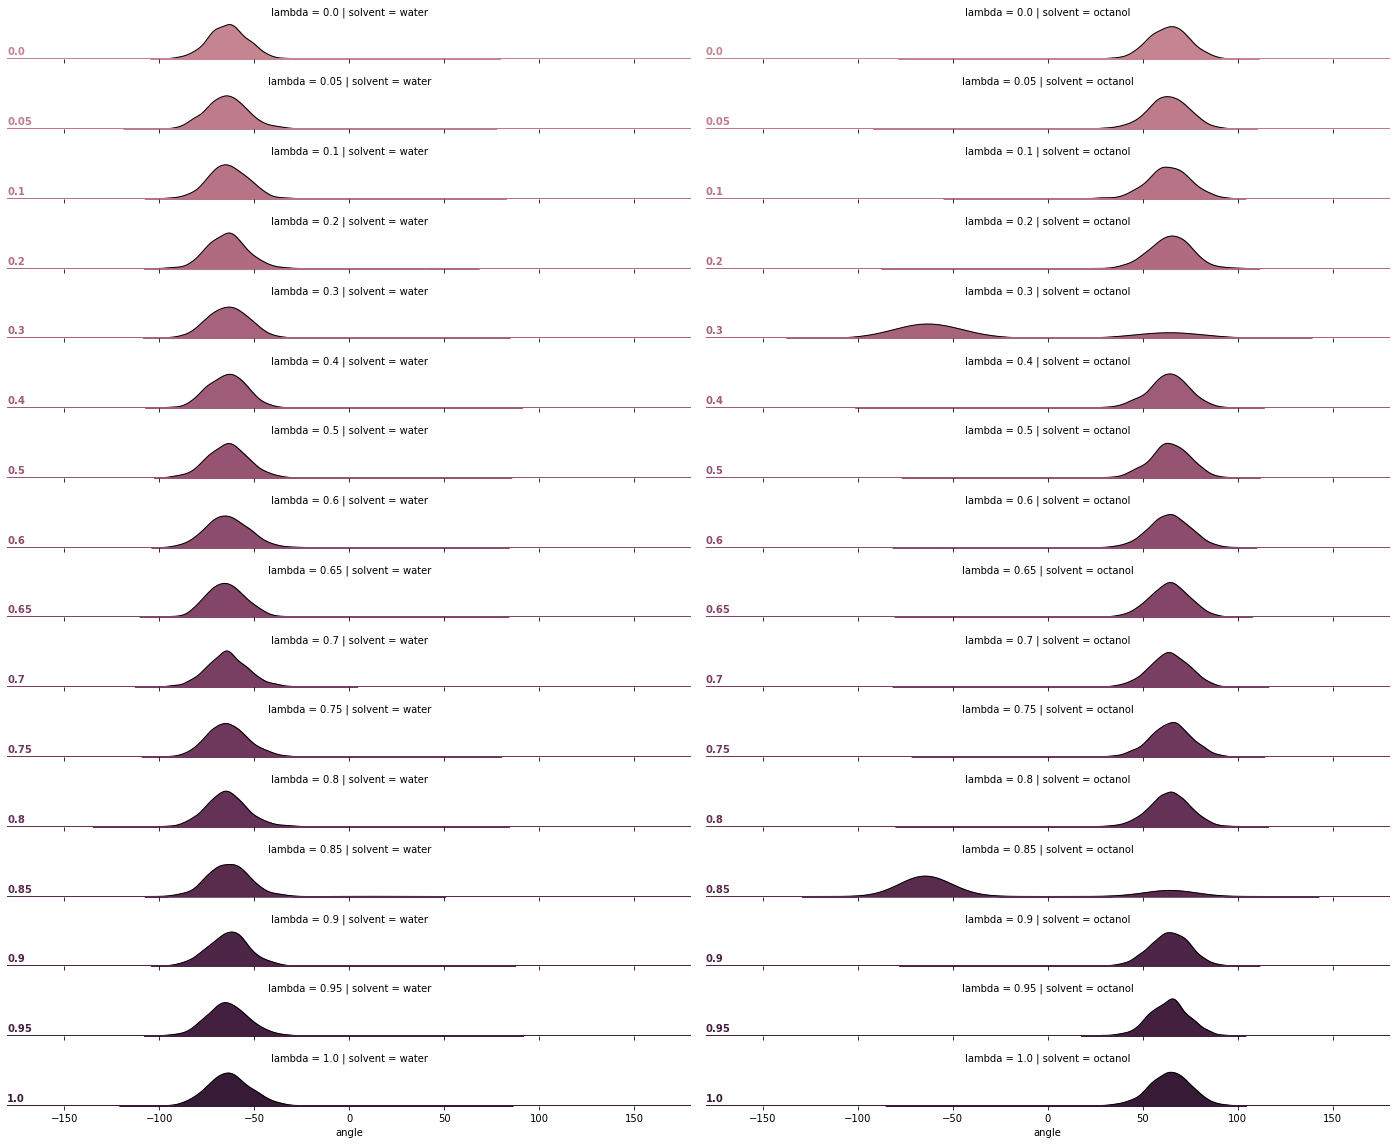

In [300]:
plot_kde_ridges(datafiles, "SM46", "oplsaa", "dih1")

100%|██████████| 32/32 [00:18<00:00,  1.72it/s]


Coulomb plot saved to ../figs/dihedrals/SM46_oplsaa_dih2_Coulomb.pdf.
VDW plot saved to ../figs/dihedrals/SM46_oplsaa_dih2_VDW.pdf.


(<seaborn.axisgrid.FacetGrid at 0x7fda3c1ad3a0>,
 <seaborn.axisgrid.FacetGrid at 0x7fda476f27f0>)

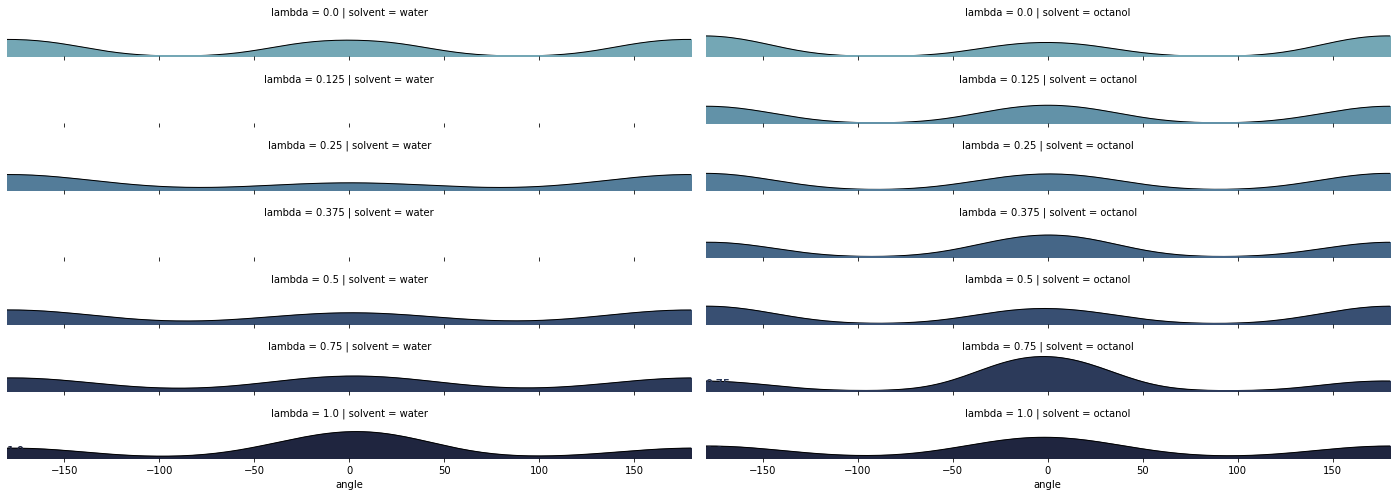

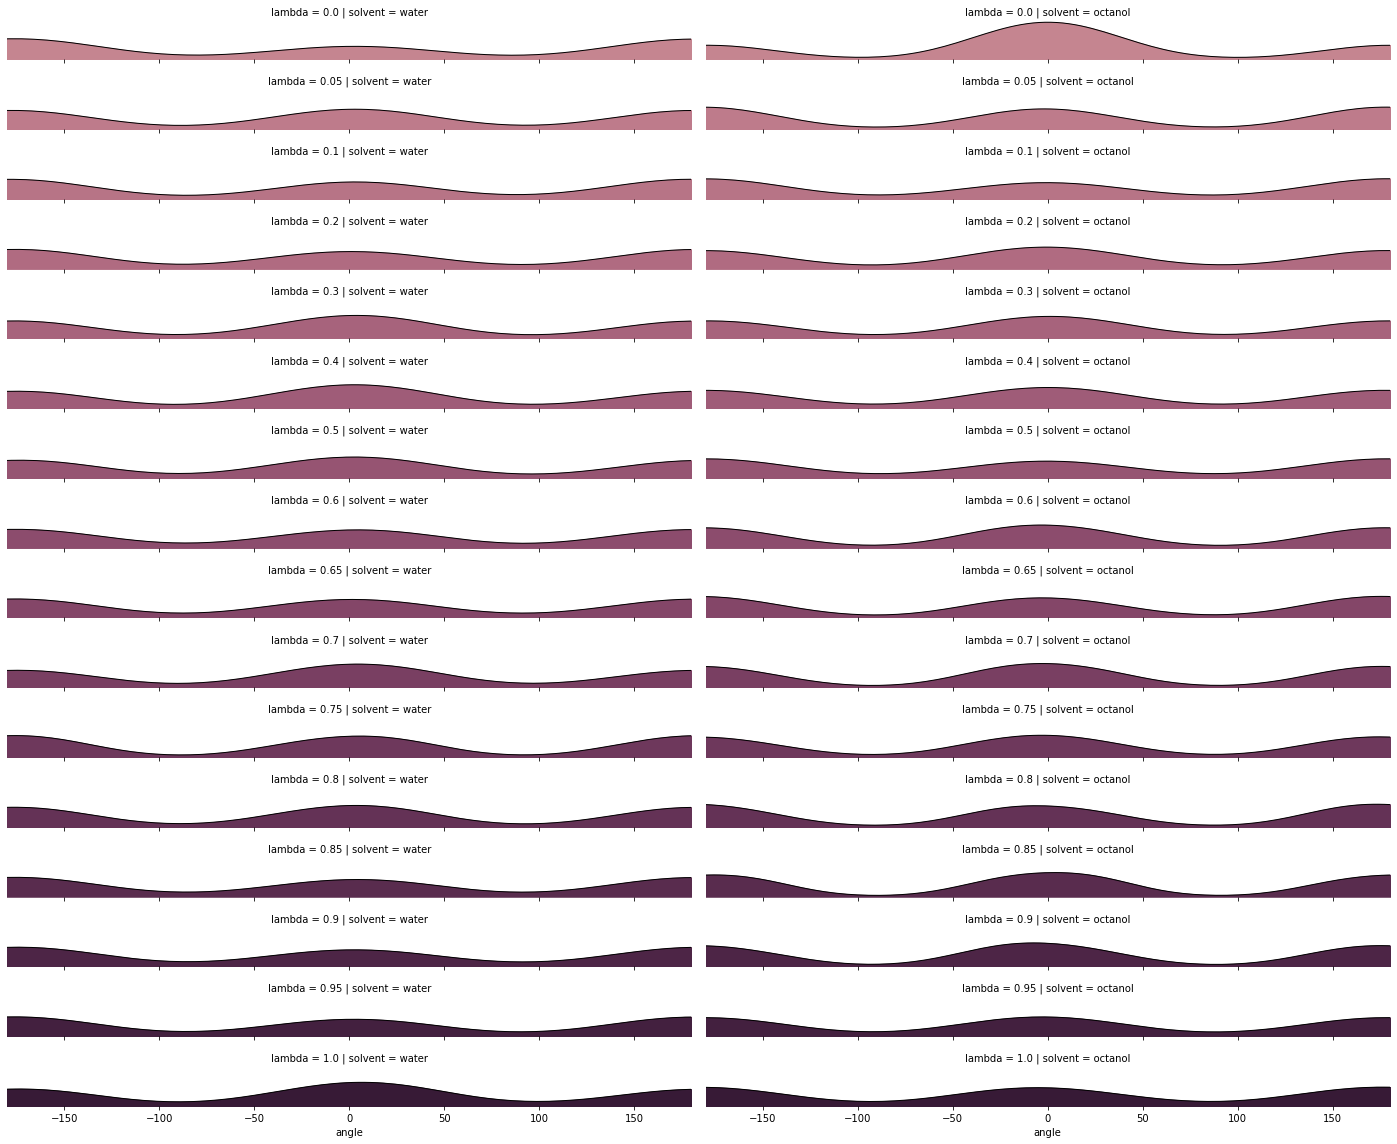

In [301]:
plot_kde_ridges(datafiles, "SM46", "oplsaa", "dih2")